In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11,12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v2'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cpu') # cuda:5
model_version = '2024_0820_214905'
CHECKPOINT_PATH = None
CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='split', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 49
Loaded checkpoint.


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = False

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            vis_result = viz(batch,pred)
    # if i ==5:
    
            break   
model.metrics.update(pred,batch)


Stage 2
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor([[[0.4925, 0.5902]],

        [[0.4896, 0.5626]],

        [[0.4841, 0.3826]],

        [[0.4860, 0.6645]],

        [[0.4847, 0.4165]],

        [[0.4873, 0.3836]],

        [[0.4930, 0.4096]],

        [[0.4855, 0.7032]]])
Stage 2
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor([[[0.4905, 0.5983]],

        [[0.4872, 0.5685]],

        [[0.4812, 0.3755]],

        [[0.4832, 0.6782]],

        [[0.4819, 0.4111]],

        [[0.4846, 0.3767]],

        [[0.4907, 0.4042]],

        [[0.4827, 0.7194]]])


In [4]:
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)

Text(0.5, 1.0, 'Prediction')

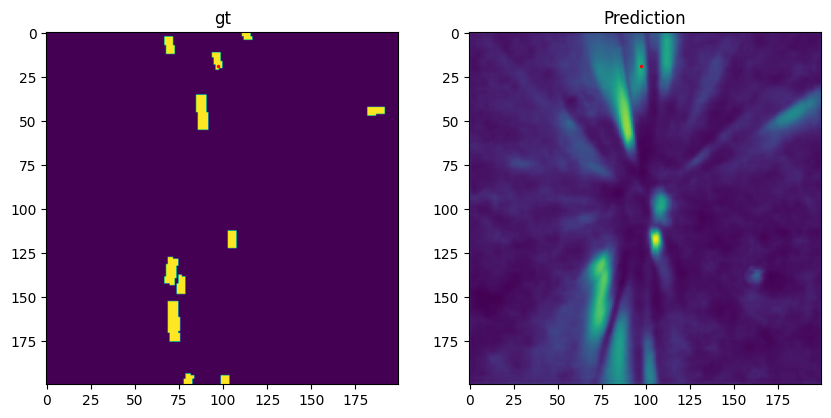

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
y = 19
x = 97
vehicle_idx = [[4,5,6,7,8,10,11]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[0,0].cpu().numpy())
ax1.scatter([x],[y], s=2, c='r')
ax1.set_title('gt')

ax2.imshow(((pred['VEHICLE'][0,0].sigmoid().detach().cpu())).numpy())
ax2.scatter([x],[y], s=2, c='r')
ax2.set_title('Prediction')

In [6]:
y = 20
x = 96
print(pred['height'][0,:,y,x], batch['height'][0,0,y,x])

# y = 25
# x = 96
# print(pred['height'][0,:,y,x], batch['height'][0,0,y,x])


tensor([-0.0144,  3.9335]) tensor(0.9320)


In [7]:
for i in range(10):
    print(pred['height'][0,:,y+i,x], batch['height'][0,0,y+i,x], y+i)

tensor([-0.0144,  3.9335]) tensor(0.9320) 20
tensor([-0.0132,  3.9354]) tensor(0.9320) 21
tensor([-0.0132,  3.9354]) tensor(0.) 22
tensor([-0.0128,  3.9357]) tensor(0.) 23
tensor([-0.0138,  3.9341]) tensor(0.) 24
tensor([-0.0117,  3.9320]) tensor(0.) 25
tensor([-0.0117,  3.9317]) tensor(0.) 26
tensor([-0.0070,  3.9364]) tensor(0.) 27
tensor([-0.0075,  3.9374]) tensor(0.) 28
tensor([-0.0075,  3.9399]) tensor(0.) 29


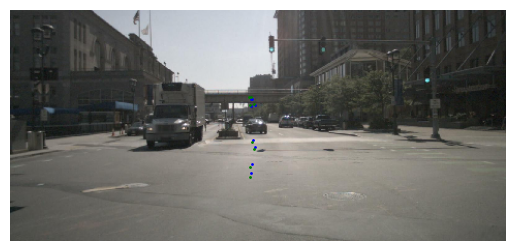

In [8]:
# mean height supervised
x = [[[0.4925, 0.5902]],

        [[0.4896, 0.5626]],

        [[0.4841, 0.3826]],

        [[0.4860, 0.6645]],

        [[0.4847, 0.4165]],

        [[0.4873, 0.3836]],

        [[0.4930, 0.4096]],

        [[0.4855, 0.7032]]]

y = [[[0.4905, 0.5983]],

        [[0.4872, 0.5685]],

        [[0.4812, 0.3755]],

        [[0.4832, 0.6782]],

        [[0.4819, 0.4111]],

        [[0.4846, 0.3767]],

        [[0.4907, 0.4042]],

        [[0.4827, 0.7194]]]
# [[[0.3613, 0.4691]],

#         [[0.3504, 0.4794]],

#         [[0.3512, 0.4666]],

#         [[0.3532, 0.4743]],

#         [[0.3519, 0.4691]],

#         [[0.3686, 0.4761]],

#         [[0.3512, 0.4649]],

#         [[0.3527, 0.5019]]]

x = np.array(x)[:,0]
x[:, 0] *= 480
x[:, 1] *= 224

y = np.array(y)[:,0]
y[:, 0] *= 480
y[:, 1] *= 224

plt.imshow(batch['image'][0,1].cpu().permute(1,2,0))
plt.scatter(x[:,0],x[:,1],s=1, c='b')
plt.scatter(y[:,0],y[:,1],s=1, c='g')
plt.axis('off')
plt.show()

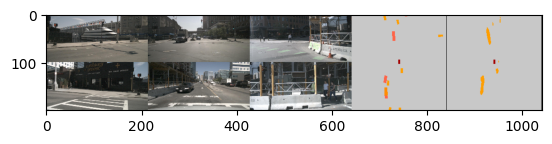

In [9]:
plt.imshow(vis_result[0])

In [10]:
# batch = dataset.__getitem__(600)
# result = viz.visualize_bev(batch['bev'],batch['view'].cpu().numpy())
# plt.imshow(result)